# Dynamic Perturbation Dataset Analysis: Neural Trajectory and Stimulation Effects

## Overview

This notebook provides a comprehensive analysis of neural data from a spinal cord stimulation dataset, with a focus on understanding how stimulation affects neural trajectories and responses. The analysis includes data preprocessing, trajectory visualization, and dimensionality reduction techniques to explore the effects of different stimulation parameters.

## Key Objectives

1. **Data Preprocessing**:
   - Load and preprocess neural data from the spinal cord stimulation dataset.
   - Perform necessary steps such as time-binning, filtering, and signal transformation.

2. **Trajectory Visualization**:
   - Visualize movement trajectories and corresponding neural activity during baseline and stimulation trials.
   - Compare positional and neuronal data across different conditions to understand the impact of stimulation.

3. **Dimensionality Reduction**:
   - Apply UMAP and PCA to the neural data to visualize the separation of different stimulation parameters.
   - Compare UMAP and PCA in terms of their effectiveness in distinguishing between stimulation conditions.

## Notebook Structure

1. **Imports and Setup**:
   - Import necessary libraries and modules for data processing, visualization, and analysis.

2. **Data Loading and Preprocessing**:
   - Load the dynamic perturbation dataset.
   - Execute preprocessing steps including time-binning, neuron filtering, signal transformation, and merging signals.

3. **Trajectory Visualization**:
   - Visualize the movement trajectories and neural activity during baseline and stimulation trials.
   - Analyze the impact of stimulation on neural trajectories and motor intention decoding.

4. **Dimensionality Reduction and Stimulation Analysis**:
   - Apply UMAP and PCA for dimensionality reduction.
   - Visualize how well different stimulation parameters are separated in the reduced dimensional space.

## Purpose

The purpose of this notebook is to analyze the effects of spinal cord stimulation on neural activity. By visualizing and reducing the dimensionality of the data, we aim to better understand how different stimulation parameters influence neural responses and trajectories.


## Imports

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import sys

sys.path.append('..')
from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Add PyalData folder to the path to import all modules

In [2]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

In [4]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

# Part 1: Data Trajectory Visualization (Stimulation Dataset)

## Load the data

In [5]:
data_dir = "../Data"
fname = os.path.join(data_dir, "Sansa_20180507.mat") #--> only 7 baseline reaches

In [6]:
# load TrialData .mat file into a DataFrame
group_df = mat2dataframe(fname, shift_idx_fields=True, td_name='grp')

array field StimParamNames could not be converted to int.


/home/nerea/CL_UpperLimb_Control/PyalData/pyaldata/data_cleaning.py:68: RuntimeWarning: invalid value encountered in cast
  int_arrays = [np.int32(arr) for arr in df[field]]


In [7]:
trial_df = mat2dataframe_NC(fname, shift_idx_fields=True, td_name = 'trial_data') 

/home/nerea/CL_UpperLimb_Control/PyalData/pyaldata/data_cleaning.py:68: RuntimeWarning: invalid value encountered in cast
  int_arrays = [np.int32(arr) for arr in df[field]]


array field kin_names could not be converted to int.
array field joint_names could not be converted to int.
array field stim_param_names could not be converted to int.
field idx_sent_pull could not be converted to int.
field idx_bad could not be converted to int.
field idx_decode_reach could not be converted to int.
field idx_sent_reach could not be converted to int.


The main dataframe here is trial_df, the group one will be used if needed to add some variables to the other one.

In [8]:
df = trial_df

`Note` Here not sure if there should be a combination of bins to make it longer and incude more spikes, but I will keep if as the demo, with now 20ms bins. 

#### **Combine time-bins into longer ones**

In [9]:
td = combine_time_bins(df, 2)
# now each bin corresponds to 20ms of recording.

#### **Remove low-firing neurons**

In [10]:
td = remove_low_firing_neurons(td, "M1_spikes",  5)
td = remove_low_firing_neurons(td, "PMd_spikes", 5)

print("original: ", df.M1_spikes[0].shape)
print("removed:  ", td.M1_spikes[0].shape)

original:  (9222, 64)
removed:   (4611, 60)


/home/nerea/CL_UpperLimb_Control/PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/nerea/CL_UpperLimb_Control/PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


#### **Transform signals**

In [11]:
td = transform_signal(td, "M1_spikes",  'sqrt')
td = transform_signal(td, "PMd_spikes", 'sqrt')
#here we change the motor and premotor cortex spikes by their square root

#### **Merge signals from multiple areas**

Signals from the pre-motor and motor cortex are now combines in one same variable, we do not consider the 2 regions as different but more as functionally working together.

In [12]:
td = merge_signals(td, ["M1_spikes", "PMd_spikes"], "both_spikes")

print(f"Merging M1 and PMd gives {td.M1_spikes[0].shape[1]} + {td.PMd_spikes[0].shape[1]} = {td.both_spikes[0].shape[1]} neurons")

Merging M1 and PMd gives 60 + 64 = 124 neurons


#### **Calculate firing rates from spikes**

In [13]:
# works on "_spikes" fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth')

#### **Keep only the successful trials**

#### For this part of the project we do not need perfect reach trials, only to decode the motor intention in baseline trials.

In [14]:
td.head(3)

,kin_names,joint_names,bin_size,type,tonic_stim_params,reach_stim_params,pull_stim_params,stim_param_names,file_quality,idx_spike_init,...,angles,pressure,M1_spikes,M1_unit_guide,PMd_spikes,PMd_unit_guide,both_spikes,M1_rates,PMd_rates,both_rates
0,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",0,224,...,"[[131.3609671373651, 62.778435057557694, 129.9...","[-1.1113413890635988, -1.1154173470554491, -1....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[11.223358, 0.6093754, 11.223935, 17.326077, ...","[[0.89774776, 6.201795, 22.478214, 6.412494, 5...","[[11.223358, 0.6093754, 11.223935, 17.326077, ..."
1,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BASELINE,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]","[PIN, AMP, PW, FREQ, Length]",1,253,...,"[[125.08886683047811, 91.06038841870912, 132.7...","[-1.0971460132308914, -1.1326079009804841, -1....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0...","[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 6.117056, 0.0, 0.0, 0.014914651, 0.0, 0...","[[8.236052, 1.8339405, 8.251045, 28.87452, 50....","[[0.0, 6.117056, 0.0, 0.0, 0.014914651, 0.0, 0..."
2,"[Shoulder, Elbow Proximal, Elbow Medial, Elbow...","[Shoulder, Elbow, Wrist]",0.02,BC-PULL,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.0, 900.0, 0.3, 50.0, 600.0]","[PIN, AMP, PW, FREQ, Length]",0,278,...,"[[129.73603167442403, 54.73211262243076, 120.8...","[-1.1155262707048532, -1.1184089790756042, -1....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[33, 0], [34, 0], [35, 0], [36, 0], [37, 0], ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.6061999, 0.0, 0.0, 0.6061999, 22.010677, 0...","[[0.6667771, 0.0031754556, 13.162496, 3.020980...","[[0.6061999, 0.0, 0.0, 0.6061999, 22.010677, 0..."


FROM HERE WORK ON DIVIDING TRIALS BY THE DIFFERENT REACHES AND COMBINING ALL TO FEED DECODERS


In [15]:
td['idx_end_complete'] = td.apply(lambda x: add_bad_idx(x['idx_end'], x['idx_bad']), axis=1)
# Apply the function to each row
td['bad_indices'] = td.apply(find_bad_indices, axis=1)
td['idx_start_test'] = td.idx_reach.apply(lambda x: x[0]).astype('int64')
td['idx_end_test'] = td.idx_end_complete.apply(lambda x: x[0]).astype('int64')

### From here testing to create tydy data and only extract windows for the reaches in each trial

In [16]:
td_all = pd.concat([td,group_df.drop(columns = 'type')], axis = 1)

In [17]:
cols_to_search = ['index', 'num', 'type', 'KUKAPos', 
               'idx_kuka_go', 'idx_reach', 'idx_end_complete',
               'bad_indices', 'x', 'y', 'z', 'angles', 'both_spikes', 'both_rates', 'file_quality']
cols_to_keep = [c for c in cols_to_search if c in td_all.columns]
td_filt = td_all[cols_to_keep]


In [18]:
td_filt = td_filt.loc[td_filt.type == 'BASELINE'].reset_index()
td_filt = td_filt.loc[td_filt.file_quality == 0].reset_index()

In [19]:
td_filt['test_start'] = td_filt['idx_reach'].apply(lambda x: x[0])

In [20]:
td_filt['test_end'] = td_filt['idx_end_complete'].apply(lambda x: x[0])

In [21]:
win_df = split_time_fields(td_filt, start_margin = 5, end_margin = 10)

In [35]:
def visualize_traj(df, pos_vars, marker_names):
    """ 
    This function is used to visualize the trajectories for given
    markers and given directions, split by reach trial.
    It makes sure that the windows have been accurately created and that 
    they include all the studies trajectories.
    
    Inputs:
        - df: DataFrame containing the trajectory data split by reach trials
        - pos_vars: list of variables to plot, can be ['x', 'y', 'z']
        - markers: list of numbers of the markers to visualize (from 0 to 5)
        
    Returns:
        Subplots of the different trajectories, split by reach trial, 
        with color code for the different trials (each trial includes several reaches)
        A single legend for the entire plot
        Also plots two different mean trajectories for each combination of pos_vars and markers

        
    """
    num_rows = len(pos_vars)
    num_cols = len(marker_names)
    
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 7))

    # Collect handles and labels for the legend
    legend_colors = ['C0', 'C1']  # Define the colors for each legend entry
    legend_labels = ['Trial 0', 'Trial 1']  # Define the labels for each legend entry

    for i, pos_var in enumerate(pos_vars):
        for j, marker in enumerate(marker_names):
            ax = axes[i, j]
            if i == 0:
                ax.set_title(f'{marker}')#, fontsize = 18)
            if j == 0:
                ax.set_ylabel(f'{pos_var.upper()} Position (mm)')#, fontsize = 18)
            
            mean_trajectories = []  # Initialize list to store mean trajectories
            
            for idx, t in enumerate(df[pos_var][:2]):
                color = f'C{idx}'  # Use a unique color for each trial
                label = f'{pos_var.upper()} Marker {marker} Trial {idx}'
                mean_trajectory = None  # Initialize mean trajectory
                
                for r in t:
                    for index_d,data in enumerate(r):
                        time = (np.arange(0, len(data[:, j])) * 20)/1000
                        ax.plot(time, data[:, j], color=color, label=label, alpha=0.4)
                        
                        # Compute mean trajectory
                        if mean_trajectory is None:
                            mean_trajectory = np.zeros_like(data[:, j])
                        mean_trajectory += data[:, j]
                
                # Store mean trajectory
                mean_trajectory /= (index_d+1) # Normalize by the number of trials
                
                #print(mean_trajectory[:10])
                mean_trajectories.append(mean_trajectory)
                #print(mean_trajectories)
            
            # Plot two different mean trajectories
            for k, mean_trajectory in enumerate(mean_trajectories):
                ax.plot(time, mean_trajectory, color=f'C{k}', linestyle='--', label=f'Mean Trajectory {k}')
            
            if i == 2:
                ax.set_xlabel('Time (s)')#, fontsize = 18)
            
    # Create a single legend outside the subplots
    legend_handles = [plt.Line2D([0], [0], color=color, lw=2, label=label) for color, label in zip(legend_colors, legend_labels)]
    legend_handles.extend([plt.Line2D([0], [0], color=f'C{k}', linestyle='--', lw=2, label=f'Mean Trajectory {k}') for k in range(len(mean_trajectories))])
    # Create a single legend for the entire figure at the bottom
    fig.legend(legend_handles, legend_labels + [f'Mean Trajectory {k}' for k in range(len(mean_trajectories))],
                loc='lower center', ncol=len(legend_labels)+2, bbox_to_anchor=(0.5, -0.1), fontsize = 'large')
    #plt.suptitle('X, Y and Z trajectories for Baseline Trials')#, fontsize='24')
    plt.tight_layout()

    plt.show()

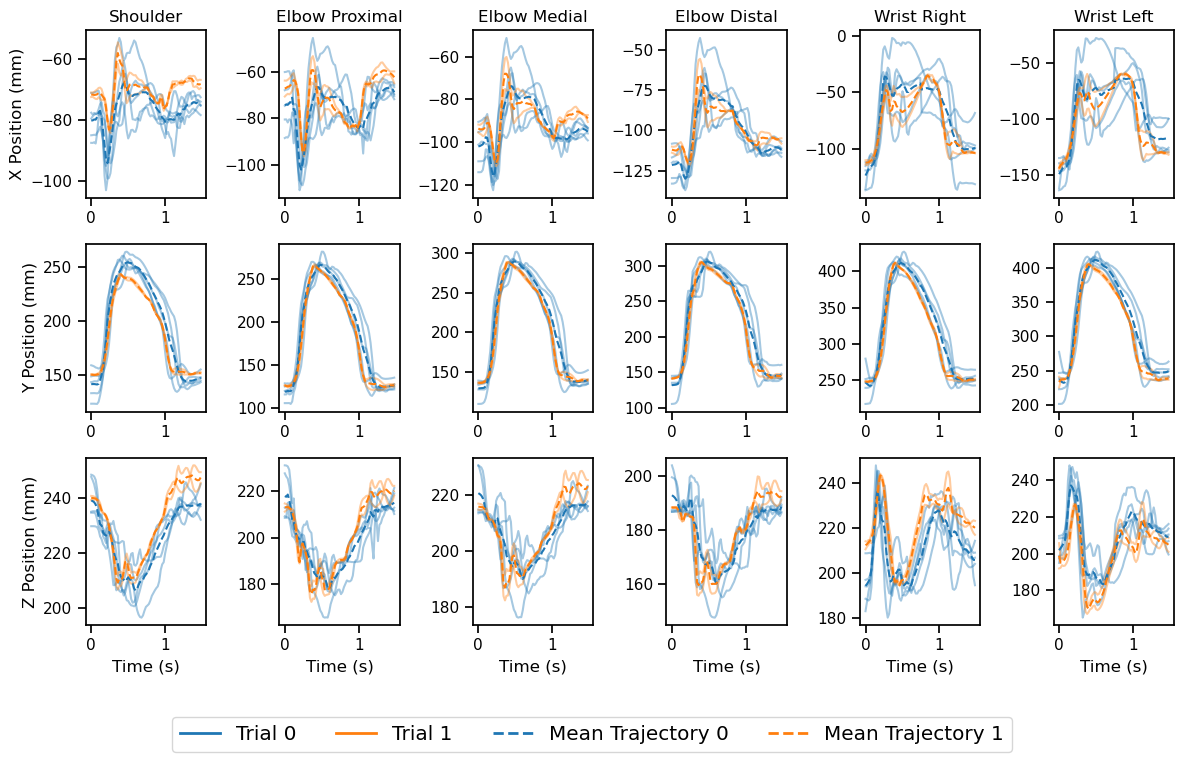

In [36]:
# Visualize the trajectories, split by reach trial
visualize_traj(win_df, ['x', 'y', 'z'], marker_names = ['Shoulder',	'Elbow Proximal', 'Elbow Medial', 'Elbow Distal', 'Wrist Right',	'Wrist Left'])  # Replace df with your actual DataFrame containing trajectory data

`Note`angle 3 is better to visualize X data and angle 4 for Y data.

In [23]:
win_df['angles'] = np.nan_to_num(win_df['angles'], nan = 0)

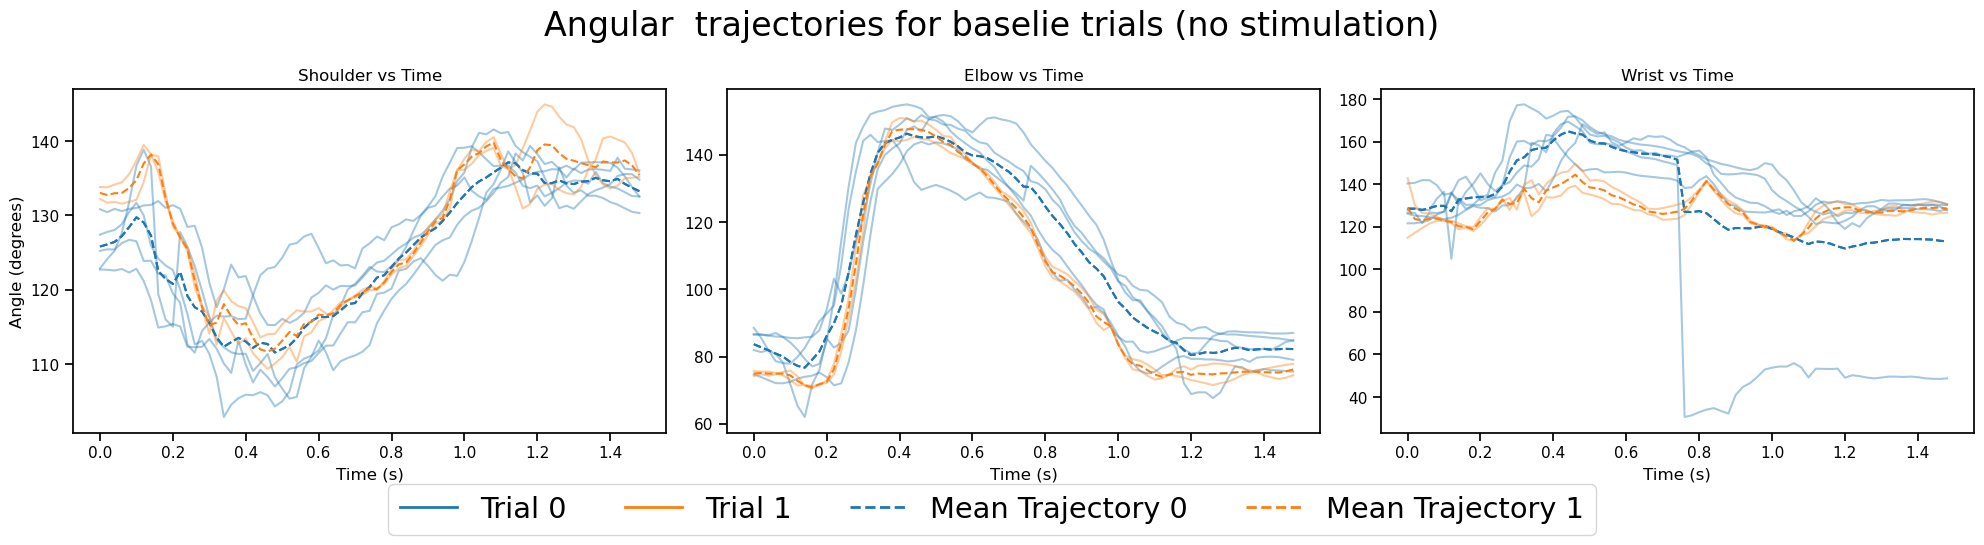

In [24]:
visualize_angles(win_df, 'angles',  angle_names = ['Shoulder', 'Elbow', 'Wrist'])

# Part 2: Differences in neural data caused by stimulation

In [39]:
def set_plot_style():
    # Define the custom color palette
    custom_palette = [
        '#5F9EA0', # cadet blue
        '#FFD700', # gold
        '#FFA07A', # light salmon
        '#87CEEB', # light blue
        '#9370DB', # medium purple
        '#98FB98'  # pale green
    ]
    
    # Set the Seaborn palette
    sns.set_palette(custom_palette)
    
    # Set general plot aesthetics
    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("whitegrid")

    # Update Matplotlib rcParams for consistent styling
    plt.rcParams.update({
        'figure.figsize': (12, 7),
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.title_fontsize': 13,
        'legend.fontsize': 11,
        'axes.titlepad': 20,
        'axes.labelpad': 10,
        'xtick.major.pad': 5,
        'ytick.major.pad': 5
    })

## Load the data

In [24]:
data_dir = "../Data"
fname = os.path.join(data_dir, "Sansa_20180413.mat")

In [25]:
# load TrialData .mat file into a DataFrame
group_df = mat2dataframe(fname, shift_idx_fields=True, td_name='grp')
trial_df = mat2dataframe_NC(fname, shift_idx_fields=True, td_name = 'trial_data')
df = trial_df
td = combine_time_bins(df, 2)
td = remove_low_firing_neurons(td, "M1_spikes",  5)
td = remove_low_firing_neurons(td, "PMd_spikes", 5)
print("original: ", df.M1_spikes[0].shape)
print("removed:  ", td.M1_spikes[0].shape)
td = transform_signal(td, "M1_spikes",  'sqrt')
td = transform_signal(td, "PMd_spikes", 'sqrt')
td = merge_signals(td, ["M1_spikes", "PMd_spikes"], "both_spikes")
print(f"Merging M1 and PMd gives {td.M1_spikes[0].shape[1]} + {td.PMd_spikes[0].shape[1]} = {td.both_spikes[0].shape[1]} neurons")
# works on "_spikes" fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth')

td['idx_end_complete'] = td.apply(lambda x: add_bad_idx(x['idx_end'], x['idx_bad']), axis=1)
# Apply the function to each row
td['bad_indices'] = td.apply(find_bad_indices, axis=1)
td_all = pd.concat([td,group_df.drop(columns = 'type')], axis = 1)
td_base = td_all.loc[td_all.type == 'BASELINE'].reset_index()
td_stim = td_all.loc[td_all.type == 'TONIC'].reset_index()

/home/nerea/CL_UpperLimb_Control/PyalData/pyaldata/data_cleaning.py:68: RuntimeWarning: invalid value encountered in cast
  int_arrays = [np.int32(arr) for arr in df[field]]
/home/nerea/CL_UpperLimb_Control/PyalData/pyaldata/data_cleaning.py:68: RuntimeWarning: invalid value encountered in cast
  int_arrays = [np.int32(arr) for arr in df[field]]


array field StimParamNames could not be converted to int.
array field kin_names could not be converted to int.
array field joint_names could not be converted to int.
array field stim_param_names could not be converted to int.
original:  (5235, 64)
removed:   (2617, 64)
Merging M1 and PMd gives 64 + 63 = 127 neurons


/home/nerea/CL_UpperLimb_Control/PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/nerea/CL_UpperLimb_Control/PyalData/pyaldata/firing_rates.py:91: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


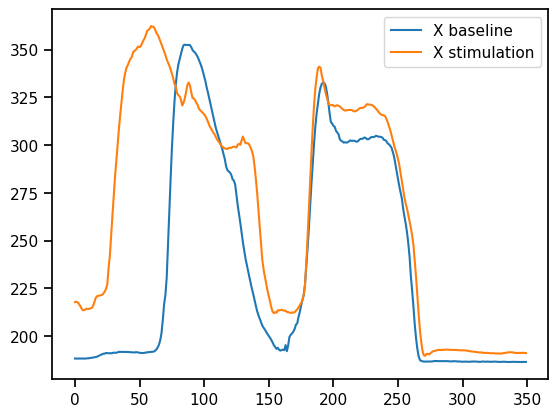

In [26]:
plt.plot(td_base.x[0][2250:2250+350,5], label = 'X baseline')
plt.plot(td_stim.x[0][2850:2850+350,5], label = 'X stimulation')
plt.legend()

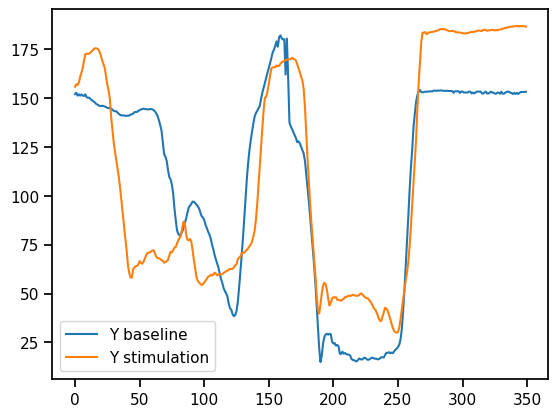

In [27]:
plt.plot(td_base.y[0][2250:2250+350,5], label = 'Y baseline')
plt.plot(td_stim.y[0][2850:2850+350,5], label = 'Y stimulation')
plt.legend()

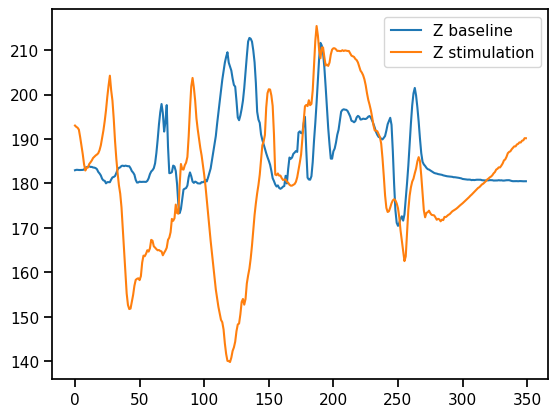

In [28]:
plt.plot(td_base.z[0][2250:2250+350,5], label = 'Z baseline')
plt.plot(td_stim.z[0][2850:2850+350,5], label = 'Z stimulation')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


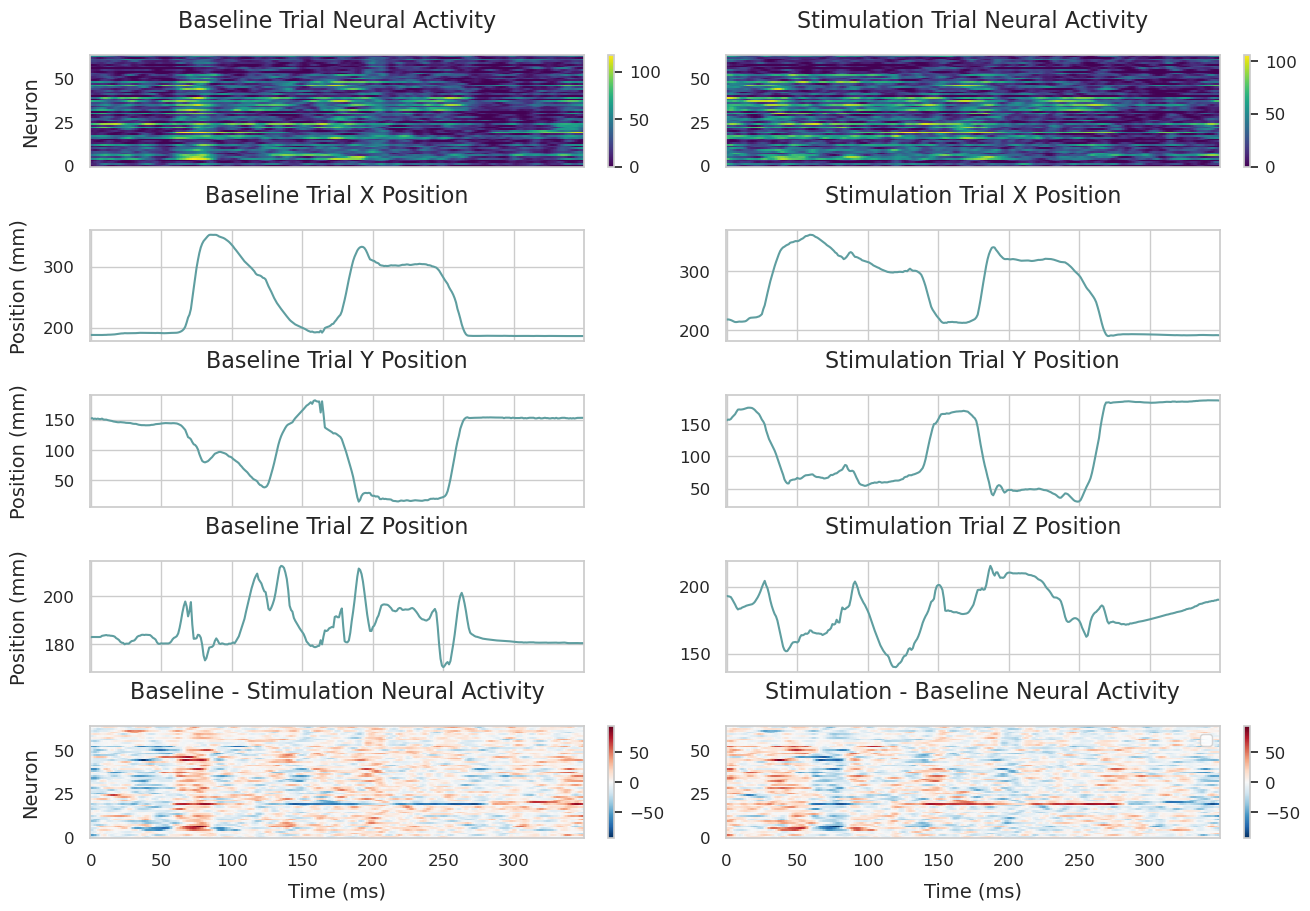

In [52]:
import matplotlib.pyplot as plt
import xarray as xr

fig, ax = plt.subplots(figsize=(13, 9), ncols=2, nrows=5, constrained_layout=True, sharex=True) 

set_plot_style()
sns.set_style("whitegrid")


xr.DataArray(td_base.M1_rates[0][2250:2250+350, :], dims=['time', 'neuron']).transpose('neuron', 'time').plot(ax=ax[0, 0])
xr.DataArray(td_stim.M1_rates[0][2850:2850+350, :], dims=['time', 'neuron']).transpose('neuron', 'time').plot(ax=ax[0, 1])
ax[0, 0].set_title('Baseline Trial Neural Activity')#, fontsize=40)
ax[0, 1].set_title('Stimulation Trial Neural Activity')#, fontsize=40)
ax[0, 0].set_ylabel('Neuron')#, fontsize=30)
ax[0, 0].set_xlabel('')#, fontsize=30)
ax[0, 1].set_xlabel('')#, fontsize=30)
ax[0, 1].set_ylabel('')#, fontsize=30)

ax[1, 0].set_xlim(0, 350)  
ax[1, 1].set_xlim(0, 350)  
ax[1, 0].plot(td_base.x[0][2250:2250+350, 5], label='X baseline')
ax[1, 1].plot(td_stim.x[0][2850:2850+350, 5], label='X stimulation')
ax[1, 0].set_title('Baseline Trial X Position')#, fontsize=30)
ax[1, 1].set_title('Stimulation Trial X Position')#, fontsize=30)
ax[1, 0].set_ylabel('Position (mm)')#, fontsize=30)



ax[2, 0].set_xlim(0, 350)  
ax[2, 1].set_xlim(0, 350)  
ax[2, 0].plot(td_base.y[0][2250:2250+350, 5], label='Y baseline')
ax[2, 1].plot(td_stim.y[0][2850:2850+350, 5], label='Y stimulation')
ax[2, 0].set_title('Baseline Trial Y Position')#, fontsize=30)
ax[2, 1].set_title('Stimulation Trial Y Position')#, fontsize=30)
ax[2, 0].set_ylabel('Position (mm)')#, fontsize=30)

ax[3, 0].set_xlim(0, 350)  
ax[3, 1].set_xlim(0, 350)  
ax[3, 0].plot(td_base.z[0][2250:2250+350, 5], label='Z baseline')
ax[3, 1].plot(td_stim.z[0][2850:2850+350, 5], label='Z stimulation')
ax[3, 0].set_title('Baseline Trial Z Position')#, fontsize=30)
ax[3, 1].set_title('Stimulation Trial Z Position')#, fontsize=30)
ax[3, 0].set_ylabel('Position (mm)')#, fontsize=30)

xr.DataArray(td_base.M1_rates[0][2250:2250+350, :] - td_stim.M1_rates[0][2850:2850+350, :], dims=['time', 'neuron']).transpose('neuron', 'time').plot(ax=ax[4, 0])
xr.DataArray(td_stim.M1_rates[0][2850:2850+350, :] - td_base.M1_rates[0][2250:2250+350, :], dims=['time', 'neuron']).transpose('neuron', 'time').plot(ax=ax[4, 1])
ax[4, 0].set_title('Baseline - Stimulation Neural Activity')#, fontsize=30)
ax[4, 1].set_title('Stimulation - Baseline Neural Activity')#, fontsize=30)
ax[4, 0].set_xlabel('Time (ms)')#, fontsize=30)
ax[4, 1].set_xlabel('Time (ms)')#, fontsize=30)
ax[4, 0].set_ylabel('Neuron')#, fontsize=30)
ax[4, 1].set_ylabel('')#, fontsize=30)

plt.tight_layout

plt.legend()
plt.show()


# Part 2: Dimensionality Reduction to classify stim params.

In [53]:
data_path = '../Data/Processed_Data/Tidy_Sansa_UMAP_0413.pkl'

with open(data_path, 'rb') as file:
    df = pickle.load(file)

In [54]:
df['stim_params'].astype(str).unique()

array(['[0 0 0 0 0]', '[2.0e+00 4.5e+02 3.0e-01 5.0e+01     nan]',
       '[2.e+00 4.e+02 3.e-01 5.e+01    nan]',
       '[2.e+00 4.e+02 3.e-01 8.e+01    nan]',
       '[2.e+00 4.e+02 3.e-01 1.e+02    nan]',
       '[8.0e+00 5.5e+02 3.0e-01 5.0e+01     nan]',
       '[8.e+00 6.e+02 3.e-01 5.e+01    nan]'], dtype=object)

In [55]:
# Assuming 'df' is your DataFrame and 'column_name' is the name of the column containing the values
# Create a mapping dictionary
mapping = {
    '[0 0 0 0 0]': 0,
    '[2.0e+00 4.5e+02 3.0e-01 5.0e+01     nan]': 1,
    '[2.e+00 4.e+02 3.e-01 5.e+01    nan]': 1,
    '[2.e+00 4.e+02 3.e-01 8.e+01    nan]': 2,
    '[2.e+00 4.e+02 3.e-01 1.e+02    nan]': 3,
    '[8.0e+00 5.5e+02 3.0e-01 5.0e+01     nan]': 4,
    '[8.e+00 6.e+02 3.e-01 5.e+01    nan]': 4
}


# params names: pin, amplitude, power, frequence, length 
# Replace values in the column using the mapping dictionary
df['stim_params'] = df['stim_params'].replace(mapping)

# Display the modified DataFrame
df.stim_params.unique()

array([0, 1, 2, 3, 4])

In [56]:
import umap

In [57]:
from umap import UMAP

In [60]:
import plotly.express as px
import umap
import numpy as np

# Assuming 'df' is already defined and 'both_rates' and 'stim_params' are columns in 'df'

# Extracting features
features = np.vstack(df['both_rates'].apply(np.array))

# UMAP projections
umap_2d = umap.UMAP(n_components=2, init='random', random_state=0)
umap_3d = umap.UMAP(n_components=3, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(features)
proj_3d = umap_3d.fit_transform(features)

# 2D Scatter Plot
fig_2d = px.scatter(
    x=proj_2d[:, 0], y=proj_2d[:, 1],
    color=df['stim_params'],
    labels={'x': 'UMAP 1', 'y': 'UMAP 2', 'color': 'Stimulation Patterns'},
    title='2D UMAP Projection'
)
fig_2d.update_traces(marker=dict(size=7, opacity=0.8), selector=dict(mode='markers'))
fig_2d.update_layout(
    title={'text': '2D UMAP Projection', 'x': 0.5, 'xanchor': 'center'},
    legend=dict(title='Stimulation Patterns')
)


# Showing the plots
fig_2d.show()


/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [61]:
# 3D Scatter Plot
fig_3d = px.scatter_3d(
    x=proj_3d[:, 0], y=proj_3d[:, 1], z=proj_3d[:, 2],
    color=df['stim_params'],
    labels={'x': 'UMAP 1', 'y': 'UMAP 2', 'z': 'UMAP 3', 'color': 'Stimulation Patterns'},
    title='3D UMAP Projection'
)
fig_3d.update_traces(marker=dict(size=3, opacity=0.8), selector=dict(mode='markers'))
fig_3d.update_layout(
    title={'text': '3D UMAP Projection of Neural Data', 'x': 0.5, 'xanchor': 'center'},
    legend=dict(title='Stimulation Pattern Groups'),
    scene=dict(
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        zaxis_title='UMAP 3'
    )
)

# Showing the plots
fig_3d.show()

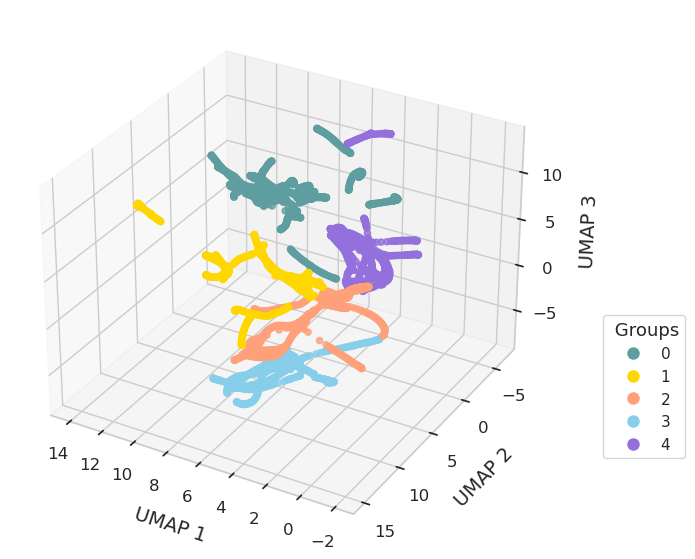

In [70]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Your custom color palette
custom_palette = [
    '#5F9EA0', # cadet blue
    '#FFD700', # gold
    '#FFA07A', # light salmon
    '#87CEEB', # light blue
    '#9370DB', # medium purple
    '#98FB98'  # pale green
]

# Example categorical data
categories = df['stim_params'].unique()

# Map each category to a color from the custom palette
color_map = {category: custom_palette[i % len(custom_palette)] for i, category in enumerate(categories)}
category_colors = df['stim_params'].map(color_map)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    proj_3d[:, 0], proj_3d[:, 1], proj_3d[:, 2],
    c=category_colors, s=20, alpha=0.8
)

# Titles and labels
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')

# Adjust the viewing angle
ax.view_init(elev=30, azim=120)

# Create a custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[cat], markersize=10, label=cat)
    for cat in categories
]

# Position the legend outside the plot area to the right
ax.legend(handles=handles, title=' Groups', loc='center left', bbox_to_anchor=(1.1, 0.3), borderaxespad=0.)

# Show plot
plt.show()




### Comparison with PCA method

In [38]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px

features = np.vstack(df['both_rates'].apply(np.array))

# PCA with 2 components
pca_2d = PCA(n_components=2, random_state=0)
proj_2d_pca = pca_2d.fit_transform(features)

# PCA with 3 components
pca_3d = PCA(n_components=3, random_state=0)
proj_3d_pca = pca_3d.fit_transform(features)

# Create 2D plot
fig_2d_pca = px.scatter(
    x=proj_2d_pca[:, 0], y=proj_2d_pca[:, 1],
    color=df['stim_params'], labels={'color': 'stim_params'}
)

# Create 3D plot
fig_3d_pca = px.scatter_3d(
    x=proj_3d_pca[:, 0], y=proj_3d_pca[:, 1], z=proj_3d_pca[:, 2],
    color=df['stim_params'], labels={'color': 'stim_params'}
)
fig_3d_pca.update_traces(marker_size=5)

# Show the plots
fig_2d_pca.show(width=1000, height=1000)
fig_3d_pca.show(width=1000, height=1000)